In [1]:
from maskrcnn_benchmark.utils.env import setup_environment
import os

import torch
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.engine.inference import inference
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.utils.collect_env import collect_env_info
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
from maskrcnn_benchmark.utils.logger import setup_logger
from maskrcnn_benchmark.utils.miscellaneous import mkdir

try:
    from apex import amp
except ImportError:
    raise ImportError('Use APEX for mixed precision via apex.amp')
    
torch.cuda.set_device(1)

num_gpus = 1
distributed = num_gpus > 1
config_file = 'configs/e2e_relation_X_101_32_8_FPN_1x.yaml'
cfg.merge_from_file(config_file)
cfg.local_rank = 0
# cfg.merge_from_list(args.opts)
cfg.MODEL.ROI_RELATION_HEAD.USE_GT_BOX = False
cfg.MODEL.ROI_RELATION_HEAD.USE_GT_OBJECT_LABEL = False
cfg.MODEL.ROI_RELATION_HEAD.PREDICTOR = 'CausalAnalysisPredictor'
cfg.MODEL.ROI_RELATION_HEAD.CAUSAL.EFFECT_TYPE = 'none'
cfg.MODEL.ROI_RELATION_HEAD.CAUSAL.FUSION_TYPE = 'sum'
cfg.MODEL.ROI_RELATION_HEAD.CAUSAL.CONTEXT_LAYER = 'motifs'
cfg.TEST.IMS_PER_BATCH = 1
cfg.DTYPE = "float16"
cfg.GLOVE_DIR= '/mnt/DATA/nmduy/glove'
cfg.MODEL.PRETRAINED_DETECTOR_CKPT = '/mnt/DATA/nmduy/pretrained_faster_rcnn/pretrained_faster_rcnn/model_final.pth'
cfg.MODEL.DEVICE = 'cuda'
cfg.OUTPUT_DIR = '/home/nmduy/Scene-Graph-Benchmark.pytorch/pretrained_causal_motif_sgdet'

cfg.freeze()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/sgg/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Set Up Model

In [2]:
model = build_detection_model(cfg)
model.to(cfg.MODEL.DEVICE);

# Initialize mixed-precision if necessary
use_mixed_precision = cfg.DTYPE == 'float16'
amp_handle = amp.init(enabled=use_mixed_precision, verbose=cfg.AMP_VERBOSE)

# Load model
output_dir = cfg.OUTPUT_DIR
checkpointer = DetectronCheckpointer(cfg, model, save_dir=output_dir)
_ = checkpointer.load(cfg.MODEL.WEIGHT)
model.eval();

iou_types = ("bbox",)
if cfg.MODEL.MASK_ON:
    iou_types = iou_types + ("segm",)
if cfg.MODEL.KEYPOINT_ON:
    iou_types = iou_types + ("keypoints",)
if cfg.MODEL.RELATION_ON:
    iou_types = iou_types + ("relations", )
if cfg.MODEL.ATTRIBUTE_ON:
    iou_types = iou_types + ("attributes", )

loading word vectors from /mnt/DATA/nmduy/glove/glove.6B.200d.pt
__background__ -> __background__ 
fail on __background__
loading word vectors from /mnt/DATA/nmduy/glove/glove.6B.200d.pt
__background__ -> __background__ 
fail on __background__


## Run SGDet

### Read Image

Create Sample Image

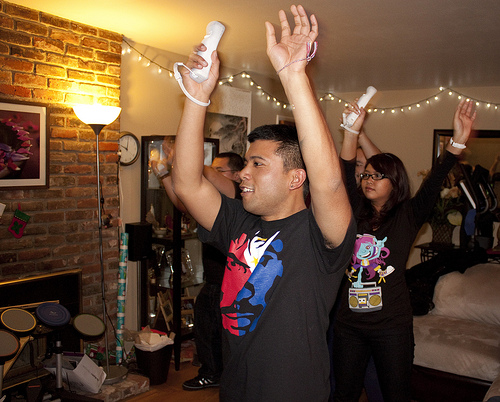

In [5]:
from PIL import Image
import requests
from io import BytesIO

def read_img_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

sample_url = 'https://cs.stanford.edu/people/rak248/VG_100K/2342560.jpg'
sample_img = read_img_from_url(sample_url)
sample_img

In [6]:
sample_img.size

(500, 402)

### Transform Image to match the format

In [7]:
from maskrcnn_benchmark.data.transforms.build import my_build_transforms
from maskrcnn_benchmark.structures.image_list import *
my_transform = my_build_transforms(cfg, is_train=False)

In [17]:
sample_img_transform = my_transform(sample_img)
# Convert to ImageList Format
sample_img_transform_iml = to_image_list(sample_img_transform, size_divisible=cfg.DATALOADER.SIZE_DIVISIBILITY)

In [18]:
print(sample_img_transform.shape)
print(sample_img_transform_iml.tensors.size())

torch.Size([3, 600, 746])

### Run Model

In [14]:
cpu_device = torch.device('cpu')
device = torch.device('cuda')
device

In [25]:
torch.cuda.empty_cache()
with torch.no_grad():
    output = model(sample_img_transform_iml.to(device))
    output = output[0]

In [26]:
output

BoxList(num_boxes=80, image_width=746, image_height=600, mode=xyxy)

In [27]:
output.extra_fields

{'pred_labels': tensor([ 78,  58, 126,  44,  78,  78,  77,  71,   8,  78,  88, 111,  30,   3,
          87,  57,  99,  99,  54,   3,  58,  44,  88,  87,  66, 149,  12, 111,
          93,  99,  97,  97,  58,  40,  58,   9,  76,   3,  46, 101, 149,   4,
           2, 106,  76, 110,  38,  66,  71,  18,  30, 149, 112,  58,  76,  46,
          46,  97,  59,  46,  18,  74,   9, 101,  58,  76,  61,  34,  18,  77,
          37,  61, 111,  53,  74,  57,   4,  67,  19,   3], device='cuda:1'),
 'pred_scores': tensor([0.1917, 0.1708, 0.0182, 0.1515, 0.1964, 0.5896, 0.3076, 0.2799, 0.0640,
         0.0111, 0.0059, 0.2955, 0.3978, 0.0751, 0.2281, 0.1604, 0.0168, 0.0161,
         0.2822, 0.1979, 0.5886, 0.0771, 0.0132, 0.0458, 0.0028, 0.0908, 0.0300,
         0.5284, 0.4362, 0.0144, 0.1518, 0.1304, 0.0294, 0.0553, 0.0669, 0.0393,
         0.0183, 0.1918, 0.0330, 0.0236, 0.0273, 0.0140, 0.0281, 0.0969, 0.3181,
         0.0059, 0.0050, 0.0280, 0.0464, 0.0460, 0.0213, 0.5220, 0.3385, 0.0895,
         0.

## Resize to the Original Image

In [28]:
original_size = sample_img.size
prediction = output.resize(original_size)

In [29]:
prediction

BoxList(num_boxes=80, image_width=500, image_height=402, mode=xyxy)

## Filter out low scores

Remove detected object containing low score (confidence). Then also refine the `rel_pair_idxs`, `pred_rel_labels`, `pred_rel_scores` fields in the result

In [30]:
import numpy as np
from maskrcnn_benchmark.structures.bounding_box import BoxList

In [66]:
def refine_boxlist(boxlist, thres_obj=0.1, thres_rel=0.1):
    device = torch.device('cpu')
    
    size = boxlist.size
    mode = boxlist.mode
    
    bbox = boxlist.bbox.to(device)
    pred_scores = boxlist.get_field('pred_scores').to(device)
    pred_labels = boxlist.get_field('pred_labels').to(device)
    pair_obj = boxlist.get_field('rel_pair_idxs').to(device)
    rel_labels = boxlist.get_field('pred_rel_labels').to(device)
    rel_scores = boxlist.get_field('pred_rel_scores').to(device)
    
    rel_scores = rel_scores.numpy()
    rel_labels = rel_labels.numpy()
    pair_obj = pair_obj.numpy()
    pred_scores = pred_scores.numpy()
    pred_labels = pred_labels.numpy()
    bbox = bbox.numpy()
    
    # Remove detected object with lower score
    idx_low_pred_labels = np.where(pred_scores < thres_obj)[0]
    idx_high_pred_labels = np.asarray([x for x in range(len(pred_scores)) if x not in list(idx_low_pred_labels)])
    
    # Remove detected relation corresponding with low score detected object
    idx_pairs_contain_low_labels = [idx for idx, row in enumerate(pair_obj) if row[0] in idx_low_pred_labels or row[1] in idx_low_pred_labels]
    idx_pairs_contain_high_labels = [x for x in range(len(rel_scores)) if x not in idx_pairs_contain_low_labels]
    
    pairs_contain_high_labels = pair_obj[idx_pairs_contain_high_labels,:]
    rel_labels_contain_high_labels = rel_labels[idx_pairs_contain_high_labels]
    rel_scores_contain_high_labels = rel_scores[idx_pairs_contain_high_labels,:]
    pred_labels_contain_high_labels = pred_labels[idx_high_pred_labels]
    pred_scores_contain_high_labels = pred_scores[idx_high_pred_labels]
    bbox_contain_high_labels = bbox[idx_high_pred_labels,:]
    
    # Reindex object in the pairs object
    temp = list(idx_high_pred_labels)
    for i in range(pairs_contain_high_labels.shape[0]):
        row = pairs_contain_high_labels[i]
        pairs_contain_high_labels[i][0] = temp.index(row[0])
        pairs_contain_high_labels[i][1] = temp.index(row[1])
        
    # Should remove detected relation with lower score
    max_scores = np.max(rel_scores_contain_high_labels[:,1:], axis=1)
    idx_high_rel = np.where(max_scores > thres_rel)[0]
    pairs_contain_high_labels_high_rels = pairs_contain_high_labels[idx_high_rel,:]
    rel_labels_contain_high_labels_high_rels = rel_labels_contain_high_labels[idx_high_rel]
    rel_scores_contain_high_labels_high_rels = rel_scores_contain_high_labels[idx_high_rel,:]
    
    newboxlist = BoxList(bbox=bbox_contain_high_labels, image_size=size, mode=mode)
    newboxlist.add_field('pred_scores', pred_scores_contain_high_labels)
    newboxlist.add_field('pred_labels', pred_labels_contain_high_labels)
    newboxlist.add_field('pred_rel_labels', rel_labels_contain_high_labels_high_rels)
    newboxlist.add_field('pred_rel_scores', rel_scores_contain_high_labels_high_rels)
    newboxlist.add_field('rel_pair_idxs', pairs_contain_high_labels_high_rels)
    
    return newboxlist

In [116]:
refine = refine_boxlist(prediction, thres_obj=0.25, thres_rel=1e-3)

In [117]:
refine.extra_fields

{'pred_scores': array([0.58959013, 0.307603  , 0.27993903, 0.29549935, 0.39783764,
        0.28217417, 0.5886248 , 0.5283566 , 0.43617764, 0.318126  ,
        0.52204585, 0.33852816, 0.630939  ], dtype=float32),
 'pred_labels': array([ 78,  77,  71, 111,  30,  54,  58, 111,  93,  76, 149, 112,  58]),
 'pred_rel_labels': array([31, 48, 48, 48, 48, 20, 20, 20, 31]),
 'pred_rel_scores': array([[3.94765764e-01, 7.24023266e-07, 3.47121243e-09, 1.08029967e-10,
         5.73742859e-11, 3.28397615e-10, 1.15222124e-10, 4.71238089e-08,
         1.59370195e-09, 4.18185153e-10, 2.84621049e-10, 7.18123304e-12,
         8.56130271e-12, 1.11421428e-09, 4.56466982e-12, 5.86115228e-12,
         1.25703403e-09, 7.16829096e-11, 8.18644527e-11, 5.79632768e-08,
         2.09052099e-11, 6.02452810e-11, 1.27042290e-06, 4.24005098e-09,
         5.95232197e-10, 9.07793025e-12, 3.90744215e-10, 9.70122767e-12,
         2.56670285e-09, 9.19043259e-08, 2.36722215e-07, 6.05231583e-01,
         1.39018695e-07, 4.702

## Decode to human

In [83]:
import json
with open('datasets/vg/VG-SGG-dicts-with-attri.json', 'r') as f:
    info_dict = json.load(f)
    
def decode_relation(pair_array, rel_label_array, label_array, info_dict):
    # relation_array size n_relation (obj1, obj2) --> encoded to number
    # rel_label_array relation label # number encoded
    # label_array is detected object encoded object
    # len(relation_array) == len(label_array)
    result = []
    for i in range(pair_array.shape[0]):
        rel = pair_array[i]
        obj1 = info_dict['idx_to_label'][str(label_array[rel[0]])]
        obj2 = info_dict['idx_to_label'][str(label_array[rel[1]])]
        con = info_dict['idx_to_predicate'][str(rel_label_array[i])]
        result.append([obj1, con, obj2])
    return result

In [118]:
relation_array = refine.get_field('rel_pair_idxs')
label_array = refine.get_field('pred_labels')
rel_labels = refine.get_field('pred_rel_labels')
#relation_and_rel_array = np.append(relation_array, rel_labels.reshape(rel_labels.shape[0],1), axis=1)

In [119]:
decode_relation(relation_array, rel_labels, label_array, info_dict)

[['logo', 'on', 'shirt'],
 ['man', 'wearing', 'shirt'],
 ['woman', 'wearing', 'shirt'],
 ['woman', 'wearing', 'glass'],
 ['man', 'wearing', 'shoe'],
 ['man', 'has', 'hand'],
 ['shirt', 'has', 'logo'],
 ['man', 'has', 'hand'],
 ['light', 'on', 'lamp']]

## Visualize object

In [89]:
import cv2
import matplotlib.pyplot as plt

In [106]:
# sample_img
# refine
sample_img_np = np.asarray(sample_img)
bbox = refine.bbox.numpy()
bbox_label = refine.get_field('pred_labels')

In [107]:
for idx in range(bbox.shape[0]):
    box = bbox[idx]
    label = info_dict['idx_to_label'][str(bbox_label[idx])] + ':' + str(idx)
    cv2.rectangle(sample_img_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    cv2.putText(sample_img_np, label, (box[0], box[1]), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,0,0), 1)

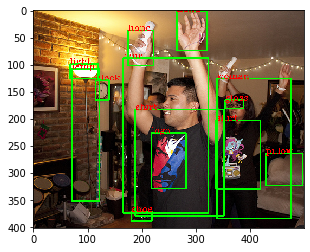

In [108]:
plt.imshow(sample_img_np)
plt.show()

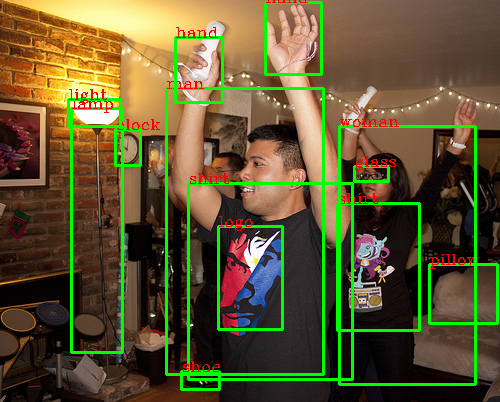

In [109]:
temp = Image.fromarray(sample_img_np)
temp